# Reading/Fetching Data

In [110]:
import yfinance as yf
import datetime

# Set the ticker symbol for USD/IDR
ticker = "USDIDR=X"

# Define the data interval (use '1d' for daily or '1h' for hourly data)
interval = '1d'  # Change to '1h' for hourly data

# Download the historical data
# Define the start and end dates, e.g., for the past year

# Get today's date
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

yahoo_data = yf.download(ticker, start="2011-11-30", end=end_date, interval=interval)

# Reset index to turn 'date' from index into a column
yahoo_df = yahoo_data.reset_index()

# Rename the columns
yahoo_df.columns = ['date', 'adj_close', 'close', 'high', 'low', 'open', 'volume']

# Select and reorder columns as specified
yahoo_df = yahoo_df[['date', 'open', 'high', 'low', 'close']]

# Display the updated DataFrame
yahoo_df

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close
0,2011-11-30 00:00:00+00:00,9179.950195,9179.950195,9080.900391,9120.500000
1,2011-12-01 00:00:00+00:00,9074.950195,9100.000000,8820.299805,9076.700195
2,2011-12-02 00:00:00+00:00,9097.450195,9107.450195,8826.299805,8994.950195
3,2011-12-05 00:00:00+00:00,9064.950195,9074.950195,8864.500000,9014.950195
4,2011-12-06 00:00:00+00:00,9054.950195,9087.450195,9006.799805,9016.599609
...,...,...,...,...,...
3366,2024-10-31 00:00:00+00:00,15695.500000,15751.200195,15672.500000,15695.500000
3367,2024-11-01 00:00:00+00:00,15713.000000,15794.000000,15633.200195,15713.000000
3368,2024-11-04 00:00:00+00:00,15842.000000,15842.000000,15719.000000,15842.000000
3369,2024-11-05 00:00:00+00:00,15790.000000,15791.900391,15707.700195,15790.000000


In [9]:
import requests
import time

# Define the API endpoint and parameters
url = "https://api.binance.com/api/v3/klines"
params = {
    'symbol': 'USDTIDR',
    'interval': '1d',  # or '1h' for hourly data
    'startTime': int(time.mktime(time.strptime('2023-01-01', '%Y-%m-%d')) * 1000),  # Start time as timestamp
    'endTime': int(time.mktime(time.strptime('2023-12-31', '%Y-%m-%d')) * 1000),  # End time as timestamp
    'limit': 1000,
}

# Send the GET request to fetch the OHLC data
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    ohlc_data = response.json()
    # Process or display the data
    for entry in ohlc_data:
        print(entry)
else:
    print(f"Error fetching data: {response.status_code}")

Error fetching data: 400


In [10]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
from urllib.parse import urlencode
import time

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

def binance_recursive_fetch_2(coins, interval, starttime, endtime):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        while current_time < endtime:
            # Determine the limit
            if ((int((endtime - current_time)/(1000*60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time)/(1000*60) + 1)
                
            # Construct the URL using urlencode for cleaner handling of parameters
            params = {
                'symbol': f'{coin}',
                'startTime': str(current_time),
                'interval': interval,
                'limit': str(limit)
            }
            url = f'https://api.binance.com/api/v1/klines?{urlencode(params)}'
            
            try:
                response = requests.get(url)
                response.raise_for_status()  # Raise an exception for HTTP errors
                result_list += response.json()
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for {coin}: {e}")
                break  # Stop the loop if there is an error
            
            # Update current time to the next interval's start time
            current_time = result_list[-1][0] + 60000
            timestamps.append(current_time)
            call += 1
            print(f"{datetime.fromtimestamp(current_time / 1000).strftime(DATE_FORMAT)} - status: {current_time < endtime}, time: {current_time}, limit: {call * 2}")
            
            # Throttle requests to avoid hitting rate limits
            if (call % 60) == 0:
                print('Call reaches 60, waiting for 60 seconds')
                time.sleep(60)  # Wait to avoid rate-limiting
            if timestamps.count(current_time) > 1:
                break  # Break if there's duplicate timestamp (indicating an error)
        
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = np.matrix(current_df).tolist()
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': np.matrix(data_list).tolist(), 'call': call_dict}

In [18]:
sample = binance_recursive_fetch_2(
    ['USDTIDRT'],  # List of trading pairs
    '1m',  # Interval
    starttime=int(pd.to_datetime('2018-01-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2024-12-31 23:59', utc=True).timestamp() * 1000)
)

# Display the data
sample['data']

  0%|          | 0/1 [00:00<?, ?it/s]

2020-04-17 20:40:00 - status: True, time: 1587156000000, limit: 2
2020-04-18 13:20:00 - status: True, time: 1587216000000, limit: 4
2020-04-19 06:00:00 - status: True, time: 1587276000000, limit: 6
2020-04-19 22:40:00 - status: True, time: 1587336000000, limit: 8
2020-04-20 15:20:00 - status: True, time: 1587396000000, limit: 10
2020-04-21 08:00:00 - status: True, time: 1587456000000, limit: 12
2020-04-22 00:40:00 - status: True, time: 1587516000000, limit: 14
2020-04-22 17:20:00 - status: True, time: 1587576000000, limit: 16
2020-04-23 10:00:00 - status: True, time: 1587636000000, limit: 18
2020-04-24 02:40:00 - status: True, time: 1587696000000, limit: 20
2020-04-24 19:20:00 - status: True, time: 1587756000000, limit: 22
2020-04-25 14:30:00 - status: True, time: 1587825000000, limit: 24
2020-04-26 07:10:00 - status: True, time: 1587885000000, limit: 26
2020-04-26 23:50:00 - status: True, time: 1587945000000, limit: 28
2020-04-27 16:30:00 - status: True, time: 1588005000000, limit: 30

  0%|          | 0/1 [05:57<?, ?it/s]


KeyboardInterrupt: 

In [12]:
len(sample['data'])

227700

In [13]:
# The fetched data sample
data = sample['data']

# Define the column names
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=columns)

# # Convert 'opentime' and 'closetime' from Unix timestamp to datetime
# df['opentime'] = pd.to_datetime(df['opentime'], unit='ms')
# df['closetime'] = pd.to_datetime(df['closetime'], unit='ms')

# Display the DataFrame
df

,coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote,unused
0,USDTIDRT,1717200000000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200059999,0.00,0,0.00000000,0.00,0
1,USDTIDRT,1717200060000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200119999,0.00,0,0.00000000,0.00,0
2,USDTIDRT,1717200120000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200179999,0.00,0,0.00000000,0.00,0
3,USDTIDRT,1717200180000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200239999,0.00,0,0.00000000,0.00,0
4,USDTIDRT,1717200240000,16288.00,16288.00,16288.00,16288.00,0.00000000,1717200299999,0.00,0,0.00000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227695,USDTIDRT,1730861700000,15903.00,15903.00,15899.00,15899.00,64.00000000,1730861759999,1017756.00,4,64.00000000,1017756.00,0
227696,USDTIDRT,1730861760000,15899.00,15899.00,15899.00,15899.00,65.00000000,1730861819999,1033435.00,5,65.00000000,1033435.00,0
227697,USDTIDRT,1730861820000,15875.00,15899.00,15875.00,15899.00,70.00000000,1730861879999,1112864.00,8,70.00000000,1112864.00,0
227698,USDTIDRT,1730861880000,15899.00,15899.00,15899.00,15899.00,80.00000000,1730861939999,1271920.00,7,80.00000000,1271920.00,0


In [17]:
import polars as pl
import pandas as pd

# Assuming you have the pandas DataFrame 'df' with your data

# Create a Polars DataFrame from the pandas DataFrame
usdt_idrt = pl.from_pandas(df)

# Rename columns (if needed) to match the structure you want
usdt_idrt = usdt_idrt.rename({
    'coin': 'coin',
    'opentime': 'opentime',
    'openprice': 'openprice',
    'highprice': 'highprice',
    'lowprice': 'lowprice',
    'closeprice': 'closeprice',
    'volume': 'volume',
    'closetime': 'closetime',
    'quotevolume': 'quotevolume',
    'trades': 'trades',
    'taker_buy_volume': 'taker_buy_volume',
    'taker_buy_quote': 'taker_buy_quote'
})

# Set appropriate data types for each column
usdt_idrt = usdt_idrt.with_columns([
    pl.col('coin').cast(pl.Utf8),  # coin as string
    pl.col('opentime').cast(pl.Int64),  # opentime as Int64 (milliseconds)
    pl.col('openprice').cast(pl.Float64),
    pl.col('highprice').cast(pl.Float64),
    pl.col('lowprice').cast(pl.Float64),
    pl.col('closeprice').cast(pl.Float64),
    pl.col('volume').cast(pl.Float64),
    pl.col('closetime').cast(pl.Int64),
    pl.col('quotevolume').cast(pl.Float64),
    pl.col('trades').cast(pl.Int64),
    pl.col('taker_buy_volume').cast(pl.Float64),
    pl.col('taker_buy_quote').cast(pl.Float64),
])

# Drop the 'unused' column
usdt_idrt = usdt_idrt.drop('unused')

# Display the result
usdt_idrt

coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
str,i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64
"""USDTIDRT""",1717200000000,16288.0,16288.0,16288.0,16288.0,0.0,1717200059999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200060000,16288.0,16288.0,16288.0,16288.0,0.0,1717200119999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200120000,16288.0,16288.0,16288.0,16288.0,0.0,1717200179999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200180000,16288.0,16288.0,16288.0,16288.0,0.0,1717200239999,0.0,0,0.0,0.0
"""USDTIDRT""",1717200240000,16288.0,16288.0,16288.0,16288.0,0.0,1717200299999,0.0,0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…
"""USDTIDRT""",1730861700000,15903.0,15903.0,15899.0,15899.0,64.0,1730861759999,1.017756e6,4,64.0,1.017756e6
"""USDTIDRT""",1730861760000,15899.0,15899.0,15899.0,15899.0,65.0,1730861819999,1.033435e6,5,65.0,1.033435e6
"""USDTIDRT""",1730861820000,15875.0,15899.0,15875.0,15899.0,70.0,1730861879999,1.112864e6,8,70.0,1.112864e6


In [15]:
import polars as pl

# Read parquet file
usdt_idrt = pl.read_parquet("USDT_IDRT.parquet")

usdt_idrt

coin,opentime,openprice,highprice,lowprice,closeprice,volume,closetime,quotevolume,trades,taker_buy_volume,taker_buy_quote
str,i64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64
"""USDT""",1587096000000,15603.0,15603.0,3500.0,3800.0,2111.0,1587096059999,7.9510e6,12,180.42,665115.9
"""USDT""",1587096060000,3900.0,9999.0,3121.0,9999.0,1518.8,1587096119999,8.0077e6,30,569.4,4.3036e6
"""USDT""",1587096120000,9999.0,15400.0,3121.0,15300.0,3436.21,1587096179999,4.8426e7,26,1093.32,1.5983e7
"""USDT""",1587096180000,15300.0,15399.0,3905.0,13662.0,2006.86,1587096239999,2.5022e7,20,21.7,334158.3
"""USDT""",1587096240000,13662.0,15000.0,3905.0,15000.0,1858.21,1587096299999,2.1579e7,25,473.01,6.1570e6
…,…,…,…,…,…,…,…,…,…,…,…
"""USDT""",1729727700000,15691.0,15691.0,15691.0,15691.0,0.0,1729727759999,0.0,0,0.0,0.0
"""USDT""",1729727760000,15691.0,15691.0,15691.0,15691.0,0.0,1729727819999,0.0,0,0.0,0.0
"""USDT""",1729727820000,15691.0,15691.0,15691.0,15691.0,5.0,1729727879999,78455.0,1,0.0,0.0


# Yahoo Data Test

In [111]:
# Convert the 'date' column to the desired format (YYYY-MM-DD)
yahoo_df['date'] = yahoo_df['date'].dt.strftime('%Y-%m-%d')

yahoo_df

,date,open,high,low,close
0,2011-11-30,9179.950195,9179.950195,9080.900391,9120.500000
1,2011-12-01,9074.950195,9100.000000,8820.299805,9076.700195
2,2011-12-02,9097.450195,9107.450195,8826.299805,8994.950195
3,2011-12-05,9064.950195,9074.950195,8864.500000,9014.950195
4,2011-12-06,9054.950195,9087.450195,9006.799805,9016.599609
...,...,...,...,...,...
3366,2024-10-31,15695.500000,15751.200195,15672.500000,15695.500000
3367,2024-11-01,15713.000000,15794.000000,15633.200195,15713.000000
3368,2024-11-04,15842.000000,15842.000000,15719.000000,15842.000000
3369,2024-11-05,15790.000000,15791.900391,15707.700195,15790.000000


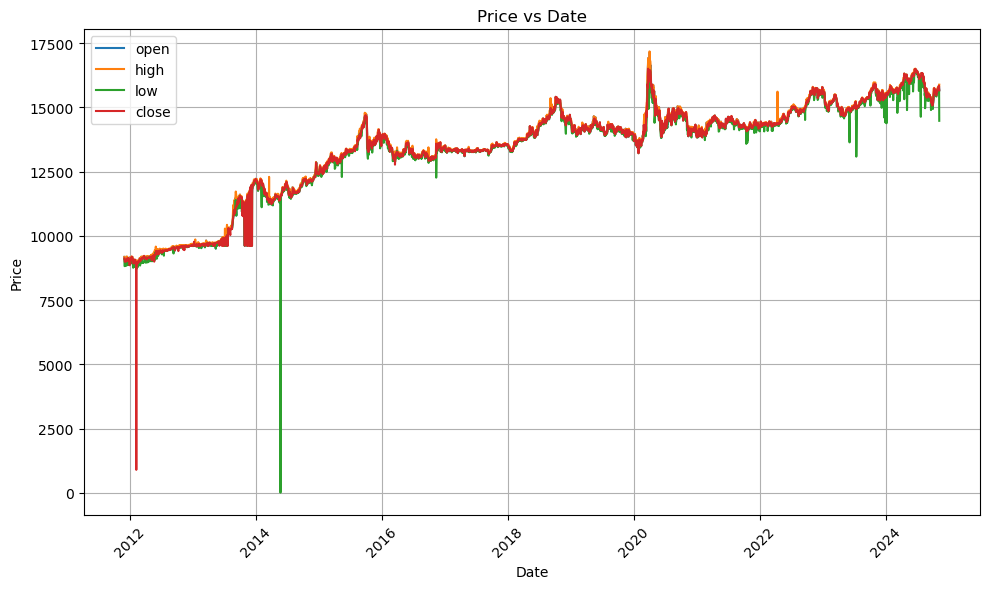

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'date' column is in datetime format for proper plotting
yahoo_df['date'] = pd.to_datetime(yahoo_df['date'])

# Convert the 'date' column to a NumPy array for plotting
date_array = yahoo_df['date'].to_numpy()

# Create a plot for each column
plt.figure(figsize=(10, 6))

# Plot each column against 'date'
for column in ['open', 'high', 'low', 'close']:
    plt.plot(date_array, yahoo_df[column].to_numpy(), label=column)

# Customize the plot
plt.title('Price vs Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

In [116]:
# Copy the df
df_feature = yahoo_df.copy()

# Ensure 'date' is consistently used as a datetime format
df_feature['date'] = pd.to_datetime(df_feature['date'])

# Features Engineering

# Create the next_close column as the target variable to be predicted
df_feature['next_close'] = df_feature['close'].shift(-1)

# Count the next day gap
df_feature['gap_day'] = df_feature['date'].shift(-1) - df_feature['date']
# Convert gap_day to just the number of days and make it an integer
df_feature['gap_day'] = df_feature['gap_day'].dt.days.fillna(0).astype(int)

# Calculate the changes from the previous row for OHLC
df_feature['open_change'] = df_feature['open'].diff()
df_feature['high_change'] = df_feature['high'].diff()
df_feature['low_change'] = df_feature['low'].diff()
df_feature['close_change'] = df_feature['close'].diff()

# Function to calculate moving average over a custom date range
def custom_moving_average(df, close_col, date_col, days):
    averages = []
    for index, row in df.iterrows():
        current_date = row[date_col]
        # Get the date range
        start_date = current_date - pd.Timedelta(days=days)
        # Filter the DataFrame for the desired date range
        mask = (df[date_col] >= start_date) & (df[date_col] <= current_date)
        # Calculate the mean for the filtered values
        avg = df.loc[mask, close_col].mean()
        averages.append(avg)
    return averages

# Calculate the custom moving averages
df_feature['ma_close_5'] = custom_moving_average(df_feature, 'close', 'date', days=4)  # 4 previous days + today
df_feature['ma_close_10'] = custom_moving_average(df_feature, 'close', 'date', days=9)  # 9 previous days + today

# Capture previous values
df_feature['prev_open'] = df_feature['open'].shift(1)
df_feature['prev_high'] = df_feature['high'].shift(1)
df_feature['prev_low'] = df_feature['low'].shift(1)
df_feature['prev_close'] = df_feature['close'].shift(1)

# Add daily range (high-low)
df_feature['daily_range'] = df_feature['high'] - df_feature['low']

# Add gap change (today's open - previous close)
df_feature['gap_change'] = df_feature['open'] - df_feature['prev_close']

# Add close-to-moving average ratios
df_feature['close_ma5_ratio'] = df_feature['close'] / df_feature['ma_close_5']
df_feature['close_ma10_ratio'] = df_feature['close'] / df_feature['ma_close_10']

# Drop columns that are not needed for prediction
df_feature = df_feature[['date', 'open', 'high', 'low', 'close', 'gap_day', 
         'next_close', 'open_change', 'high_change', 
         'low_change', 'close_change', 'ma_close_5', 
         'ma_close_10', 'prev_open', 'prev_high', 
         'prev_low', 'prev_close', 'daily_range', 'gap_change',
         'close_ma5_ratio', 'close_ma10_ratio']]

# Others Features Engineering
df_feature['open_change_perc'] = df_feature['open_change'] / df_feature['prev_open']
df_feature['high_change_perc'] = df_feature['high_change'] / df_feature['prev_high']
df_feature['low_change_perc'] = df_feature['low_change'] / df_feature['prev_low']
df_feature['close_change_perc'] = df_feature['close_change'] / df_feature['prev_close']

df_feature['prev_daily_range'] = df_feature['prev_high'] - df_feature['prev_low']
df_feature['daily_range_change'] = df_feature['daily_range'] - df_feature['prev_daily_range']

df_feature['open_prev_close_change'] = df_feature['open'] - df_feature['prev_close']

df_feature['volatility'] = ((df_feature['high'] - df_feature['low']) / df_feature['open']) * 100
df_feature['prev_volatility'] = ((df_feature['prev_high'] - df_feature['prev_low']) / df_feature['prev_open']) * 100
df_feature['volatility_change'] = df_feature['volatility'] - df_feature['prev_volatility']

# Filter the DataFrame to include only rows from the year onwards
df_feature = df_feature[df_feature['date'] >= '2014-06-01']

df_feature

,date,open,high,low,close,gap_day,next_close,open_change,high_change,low_change,...,open_change_perc,high_change_perc,low_change_perc,close_change_perc,prev_daily_range,daily_range_change,open_prev_close_change,volatility,prev_volatility,volatility_change
651,2014-06-02,11728.0,11810.000000,11707.000000,11660.0,1,11760.0,126.0,85.000000,119.000000,...,0.010860,0.007249,0.010269,0.005606,137.000000,-34.000000,133.0,0.878240,1.180831,-0.302591
652,2014-06-03,11765.0,11820.000000,11765.000000,11760.0,1,11770.0,37.0,10.000000,58.000000,...,0.003155,0.000847,0.004954,0.008576,103.000000,-48.000000,105.0,0.467488,0.878240,-0.410752
653,2014-06-04,11828.0,11900.000000,11795.000000,11770.0,1,11880.0,63.0,80.000000,30.000000,...,0.005355,0.006768,0.002550,0.000850,55.000000,50.000000,68.0,0.887724,0.467488,0.420236
654,2014-06-05,11885.0,11901.000000,11735.000000,11880.0,1,11845.0,57.0,1.000000,-60.000000,...,0.004819,0.000084,-0.005087,0.009346,105.000000,61.000000,115.0,1.396719,0.887724,0.508995
655,2014-06-06,11850.0,11852.000000,11690.000000,11845.0,3,11815.0,-35.0,-49.000000,-45.000000,...,-0.002945,-0.004117,-0.003835,-0.002946,166.000000,-4.000000,-30.0,1.367089,1.396719,-0.029630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,2024-10-31,15695.5,15751.200195,15672.500000,15695.5,1,15713.0,-72.5,-16.799805,44.400391,...,-0.004598,-0.001065,0.002841,-0.004598,139.900391,-61.200195,-72.5,0.501419,0.887242,-0.385824
3367,2024-11-01,15713.0,15794.000000,15633.200195,15713.0,3,15842.0,17.5,42.799805,-39.299805,...,0.001115,0.002717,-0.002508,0.001115,78.700195,82.099609,17.5,1.023355,0.501419,0.521936
3368,2024-11-04,15842.0,15842.000000,15719.000000,15842.0,1,15790.0,129.0,48.000000,85.799805,...,0.008210,0.003039,0.005488,0.008210,160.799805,-37.799805,129.0,0.776417,1.023355,-0.246938
3369,2024-11-05,15790.0,15791.900391,15707.700195,15790.0,1,15665.0,-52.0,-50.099609,-11.299805,...,-0.003282,-0.003162,-0.000719,-0.003282,123.000000,-38.799805,-52.0,0.533250,0.776417,-0.243167


In [117]:
df_feature['gap_day'].unique()

array([1, 3, 2, 0])

In [123]:
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = df_feature.drop(['date', 'next_close'], axis=1)
target_df = df_feature['next_close']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
num_predictions = 1   # Number of rows to predict
gap = 1               # Gap (number of rows to skip after each window)
max_windows = 50      # Maximum number of windows to process
set_limit = False     # Set this to False to process all windows

# Define list of window sizes
window_sizes = [437] # Optimum
# window_sizes = list(range(420, 441, 1))

# List to store results
results = []

# Loop through each window size
for window_size in window_sizes:

    # Initiate lists to store RMSEs and percentages
    all_val_rmse = []
    all_val_rmse_perc = []
    all_train_rmse = []
    all_train_rmse_perc = []

    # Calculate the number of windows based on dataset size
    num_windows = len(X) - window_size - num_predictions

    # Apply maximum window limit if set
    if set_limit:
        num_windows = min(num_windows, max_windows)

    # Loop through each sliding window with the gap applied
    window_number = 0
    while window_number < num_windows:
        start = window_number
        end = start + window_size
        X_train = X[start:end]
        y_train = y[start:end]

        # Prepare validation data for prediction
        X_val = X[end:end + num_predictions]
        y_val = y[end:end + num_predictions]

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)
        # Predict on training data
        y_pred_train = model.predict(X_train)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors
        all_val_rmse.append(rmse_val)
        all_val_rmse_perc.append(rmse_val_perc)
        all_train_rmse.append(rmse_train)
        all_train_rmse_perc.append(rmse_train_perc)

        # Move to the next window based on the gap
        window_number += gap

    # Calculate average, max, min, and variance for validation and training RMSEs, percentages
    avg_val_rmse = np.mean(all_val_rmse)
    # min_val_rmse = min(all_val_rmse)
    # max_val_rmse = max(all_val_rmse)
    var_val_rmse = np.var(all_val_rmse)

    avg_val_rmse_perc = np.mean(all_val_rmse_perc)
    # min_val_rmse_perc = min(all_val_rmse_perc)
    # max_val_rmse_perc = max(all_val_rmse_perc)
    var_val_rmse_perc = np.var(all_val_rmse_perc)

    avg_train_rmse = np.mean(all_train_rmse)
    # min_train_rmse = min(all_train_rmse)
    # max_train_rmse = max(all_train_rmse)
    var_train_rmse = np.var(all_train_rmse)

    avg_train_rmse_perc = np.mean(all_train_rmse_perc)
    # min_train_rmse_perc = min(all_train_rmse_perc)
    # max_train_rmse_perc = max(all_train_rmse_perc)
    var_train_rmse_perc = np.var(all_train_rmse_perc)

    # Append results to the list
    results.append({
        'window_size': window_size,
        # 'min_val_rmse': min_val_rmse,
        # 'max_val_rmse': max_val_rmse,
        'avg_val_rmse': avg_val_rmse,
        'var_val_rmse': var_val_rmse,
        # 'min_val_rmse_perc': min_val_rmse_perc,
        # 'max_val_rmse_perc': max_val_rmse_perc,
        'avg_val_rmse_perc': avg_val_rmse_perc,
        'var_val_rmse_perc': var_val_rmse_perc,
        # 'min_train_rmse': min_train_rmse,
        # 'max_train_rmse': max_train_rmse,
        'avg_train_rmse': avg_train_rmse,
        'var_train_rmse': var_train_rmse,
        # 'min_train_rmse_perc': min_train_rmse_perc,
        # 'max_train_rmse_perc': max_train_rmse_perc,
        'avg_train_rmse_perc': avg_train_rmse_perc,
        'var_train_rmse_perc': var_train_rmse_perc,
    })

    # Print results for the current window size
    print(f'Window size {window_size} | Avg Training RMSE: {avg_train_rmse:.3f}, Var Training RMSE: {var_train_rmse:.3f}')
    print(f'Window size {window_size} | Avg Validation RMSE: {avg_val_rmse:.3f}, Var Validation RMSE: {var_val_rmse:.3f}')

# Convert results to a DataFrame
results_summary = pd.DataFrame(results)

# Print the resulting DataFrame
print("\nSummary of RMSE Results for Each Window Size:")
results_summary

Window size 437 | Avg Training RMSE: 60.134, Var Training RMSE: 463.857
Window size 437 | Avg Validation RMSE: 47.709, Var Validation RMSE: 4291.721

Summary of RMSE Results for Each Window Size:


,window_size,avg_val_rmse,var_val_rmse,avg_val_rmse_perc,var_val_rmse_perc,avg_train_rmse,var_train_rmse,avg_train_rmse_perc,var_train_rmse_perc
0,437,47.708928,4291.721173,0.329184,0.201578,60.133593,463.857395,0.424372,0.022315


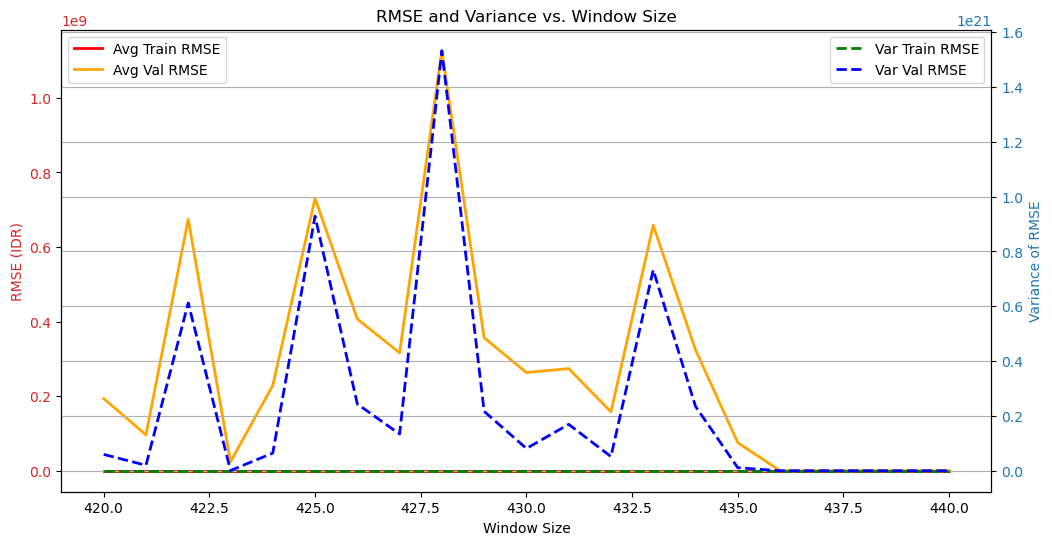

In [122]:
import matplotlib.pyplot as plt

# Ensure you have results_summary populated before running this code
if not results_summary.empty:
    # Plotting RMSE and Variance
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # RMSE Plot
    color = 'tab:red'
    ax1.set_xlabel('Window Size')
    ax1.set_ylabel('RMSE (IDR)', color=color)

    # Plot average RMSE as lines without points
    ax1.plot(results_summary['window_size'].values, results_summary['avg_train_rmse'].values, 
              label='Avg Train RMSE', color='red', linewidth=2)
    ax1.plot(results_summary['window_size'].values, results_summary['avg_val_rmse'].values, 
              label='Avg Val RMSE', color='orange', linewidth=2)

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Create a second y-axis for variance
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Variance of RMSE', color=color)  # Set the label for the second Y axis

    # Plot variance of RMSE as lines without points
    ax2.plot(results_summary['window_size'].values, results_summary['var_train_rmse'].values, 
             label='Var Train RMSE', color='green', linestyle='--', linewidth=2)
    ax2.plot(results_summary['window_size'].values, results_summary['var_val_rmse'].values, 
             label='Var Val RMSE', color='blue', linestyle='--', linewidth=2)

    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('RMSE and Variance vs. Window Size')
    plt.grid()
    plt.show()
else:
    print("Results summary is empty.")

In [125]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = df_feature.drop(['date', 'next_close'], axis=1)
target_df = df_feature['next_close']
date_df = df_feature['date']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
window_size = 437  # Optimal window size
gap = 1            # Step size of each window
num_display = 11    # Number of recent predictions to display

# Lists to store validation and training RMSEs (excluding the last window from avg calculations)
all_val_rmse = []
all_val_rmse_perc = []
all_train_rmse = []
all_train_rmse_perc = []

# Store predictions only for the final days
last_predictions = []

# Number of windows to process
num_windows = len(X) - window_size - 1  # Exclude last row for training

# Loop through each sliding window
window_number = 0
while window_number <= num_windows:
    start = window_number
    end = start + window_size
    X_train = X[start:end]
    y_train = y[start:end]

    # Prepare validation data for prediction
    if end < len(X) - 1:  # Ensure there's data for validation
        X_val = X[end:end + 1]  # Validation is the next row after the current window
        y_val = y[end:end + 1]  # The target for validation
        val_date = date_df.iloc[end:end + 1].values  # Get the date for validation

        # Skip this iteration if y_train contains NaN
        if np.isnan(y_train).any() or np.isnan(y_val).any():
            window_number += gap
            continue

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        y_pred_train = model.predict(X_train)
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors, excluding the last window from averages
        if end < len(X) - 1:  # Only add if it's not the last window
            all_val_rmse.append(rmse_val)
            all_val_rmse_perc.append(rmse_val_perc)
            all_train_rmse.append(rmse_train)
            all_train_rmse_perc.append(rmse_train_perc)

        # Check if we're in the last 3 windows to display
        if end >= len(X) - num_display:
            # Use the date for the next row as the prediction date
            next_row_date = date_df.iloc[end + 1]
            last_predictions.append((next_row_date, y_val[0], y_pred_val[0]))

    # Move to the next window based on the gap
    window_number += gap

# Use the features of the last row for prediction
if len(X) > 0:
    last_row_features = X[-1].reshape(1, -1)  # Reshape to 2D for prediction
    last_row_pred = model.predict(last_row_features)
    last_row_date = date_df.iloc[-1]

    # Append the last row prediction with the correct date
    last_predictions.append((last_row_date + pd.Timedelta(days=1), np.nan, last_row_pred[0]))

# Print the most recent predictions and actual values for the last three days
print("\nRecent Predictions and Actual Values:")
for i, (date, actual, pred) in enumerate(reversed(last_predictions)):
    if np.isnan(actual):
        print(f"Date: {date.date()}, Prediction: {pred:.0f}")
    else:
        error = abs(actual - pred)  # Calculate the absolute error
        error_perc = ((pred/actual)-1)*100
        print(f"Date: {date.date()}, Prediction: {pred:.0f}, Actual: {actual:.0f},  Error: {error:.0f}, Error %: {error_perc:.2f}%")


Recent Predictions and Actual Values:
Date: 2024-11-07, Prediction: 15803
Date: 2024-11-06, Prediction: 15751, Actual: 15665,  Error: 86, Error %: 0.55%
Date: 2024-11-05, Prediction: 15797, Actual: 15790,  Error: 7, Error %: 0.05%
Date: 2024-11-04, Prediction: 15741, Actual: 15842,  Error: 101, Error %: -0.64%
Date: 2024-11-01, Prediction: 15719, Actual: 15713,  Error: 6, Error %: 0.04%
Date: 2024-10-31, Prediction: 15727, Actual: 15696,  Error: 32, Error %: 0.20%
Date: 2024-10-30, Prediction: 15753, Actual: 15768,  Error: 15, Error %: -0.10%
Date: 2024-10-29, Prediction: 15709, Actual: 15747,  Error: 38, Error %: -0.24%
Date: 2024-10-28, Prediction: 15636, Actual: 15688,  Error: 52, Error %: -0.33%
Date: 2024-10-25, Prediction: 15610, Actual: 15622,  Error: 12, Error %: -0.08%
Date: 2024-10-24, Prediction: 15663, Actual: 15663,  Error: 0, Error %: 0.00%


In [88]:
import polars as pl

# Read parquet file
usdt_idrt = pl.read_parquet("USDT_IDRT.parquet")

# Convert to Pandas DataFrame
usdt_idrt = usdt_idrt.to_pandas()
usdt_idrt

usdt_idrt['opentime'] = pd.to_datetime(usdt_idrt['opentime'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
usdt_idrt['closetime'] = pd.to_datetime(usdt_idrt['closetime'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert 'opentime' and 'closetime' to datetime
usdt_idrt['opentime'] = pd.to_datetime(usdt_idrt['opentime'])
usdt_idrt['closetime'] = pd.to_datetime(usdt_idrt['closetime'])

# Calculate Volume-Weighted Average Price (VWAP)
usdt_idrt['vwap'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'vwap'] = usdt_idrt['quotevolume'] / usdt_idrt['volume']

# Calculate Average Trade Size
usdt_idrt['avg_trade_size'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['trades'] != 0, 'avg_trade_size'] = usdt_idrt['volume'] / usdt_idrt['trades']

# Calculate Trade Count Change (difference in trades from previous row)
usdt_idrt['trade_count_change'] = usdt_idrt['trades'].diff()

# Calculate Taker Buy Volume Ratio
usdt_idrt['taker_buy_volume_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'taker_buy_volume_ratio'] = usdt_idrt['taker_buy_volume'] / usdt_idrt['volume']

# Calculate Taker Buy Quote Ratio
usdt_idrt['taker_buy_quote_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['quotevolume'] != 0, 'taker_buy_quote_ratio'] = usdt_idrt['taker_buy_quote'] / usdt_idrt['quotevolume']

# Calculate Daily Volume Change
usdt_idrt['daily_volume_change'] = usdt_idrt['volume'].diff()

# Calculate Daily Quote Volume Change
usdt_idrt['daily_quote_volume_change'] = usdt_idrt['quotevolume'].diff()

# Calculate Buy/Sell Volume Imbalance
usdt_idrt['buy_sell_volume_imbalance'] = abs(usdt_idrt['taker_buy_volume'] - (usdt_idrt['volume'] - usdt_idrt['taker_buy_volume']))

# Calculate Relative Volume (volume compared to 5-period MA of volume)
usdt_idrt['ma_volume_5'] = usdt_idrt['volume'].rolling(window=5).mean()
usdt_idrt['relative_volume'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['ma_volume_5'] != 0, 'relative_volume'] = usdt_idrt['volume'] / usdt_idrt['ma_volume_5']

# Calculate Volume Volatility (standard deviation of volume over a rolling window)
usdt_idrt['volume_volatility'] = usdt_idrt['volume'].rolling(window=5).std()

# Volume Spike Indicator (1 if volume > 1.5 times the 5-period moving average, else 0)
usdt_idrt['volume_spike'] = (usdt_idrt['volume'] > 1.5 * usdt_idrt['ma_volume_5']).astype(int)

# Calculate Price-to-Volume Ratio
usdt_idrt['price_to_volume_ratio'] = 0  # Default to 0
usdt_idrt.loc[usdt_idrt['volume'] != 0, 'price_to_volume_ratio'] = usdt_idrt['closeprice'] / usdt_idrt['volume']

# Calculate Trade Frequency per Minute (assuming 1-minute intervals in the data)
usdt_idrt['trades_per_minute'] = usdt_idrt['trades']  # Assuming this is valid as it is

# Calculate Taker Buy Volume Change
usdt_idrt['taker_buy_volume_change'] = usdt_idrt['taker_buy_volume'].diff()

# Drop the intermediate 'ma_volume_5' column if it is no longer needed
usdt_idrt = usdt_idrt.drop(columns=['ma_volume_5'])

# Calculate duration in minutes
usdt_idrt['duration_minutes'] = (usdt_idrt['closetime'] - usdt_idrt['opentime']).dt.total_seconds() / 60

# Drop rows with NaN values
usdt_idrt = usdt_idrt.dropna()

# First, make sure 'opentime' is set as the DataFrame index or create a 'date' column.
usdt_idrt['date'] = usdt_idrt['opentime'].dt.date

# Group by date and aggregate features
daily_agg = usdt_idrt.groupby('date').agg({
    'openprice': 'first',
    'highprice': 'max',
    'lowprice': 'min',
    'closeprice': 'last',
    'volume': 'sum',
    'quotevolume': 'sum',
    'vwap': 'mean',
    'avg_trade_size': 'mean',
    'trade_count_change': 'mean',
    'taker_buy_volume_ratio': 'mean',
    'daily_volume_change': 'mean',  # You might want to sum or calculate the mean
    'buy_sell_volume_imbalance': 'mean',
    'relative_volume': 'mean',
    'volume_volatility': 'mean',
    'volume_spike': 'sum',  # Count the number of spikes
    'price_to_volume_ratio': 'mean',
    'trades_per_minute': 'sum',  # Total number of trades
    'taker_buy_volume_change': 'mean'
}).reset_index()

# Optionally, you can rename the columns for clarity
daily_agg.columns = ['date', 'daily_open', 'daily_high', 'daily_low', 'daily_close', 
                     'total_volume', 'total_quote_volume', 'avg_vwap', 'avg_trade_size',
                     'avg_trade_count_change', 'avg_taker_buy_volume_ratio', 
                     'daily_volume_change', 'avg_buy_sell_volume_imbalance', 
                     'avg_relative_volume', 'avg_volume_volatility', 
                     'count_volume_spikes', 'avg_price_to_volume_ratio', 
                     'total_trades', 'avg_taker_buy_volume_change']

# Display the aggregated DataFrame
daily_agg

/tmp/ipykernel_2192050/1995931850.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3766.46045476  5272.37658019 14092.81954537 ... 15692.
 15691.         15693.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  usdt_idrt.loc[usdt_idrt['volume'] != 0, 'vwap'] = usdt_idrt['quotevolume'] / usdt_idrt['volume']
/tmp/ipykernel_2192050/1995931850.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[175.91666667  50.62666667 132.16192308 ...   3.           5.
   5.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  usdt_idrt.loc[usdt_idrt['trades'] != 0, 'avg_trade_size'] = usdt_idrt['volume'] / usdt_idrt['trades']
/tmp/ipykernel_2192050/1995931850.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future er

,date,daily_open,daily_high,daily_low,daily_close,total_volume,total_quote_volume,avg_vwap,avg_trade_size,avg_trade_count_change,avg_taker_buy_volume_ratio,daily_volume_change,avg_buy_sell_volume_imbalance,avg_relative_volume,avg_volume_volatility,count_volume_spikes,avg_price_to_volume_ratio,total_trades,avg_taker_buy_volume_change
0,2020-04-17,13662.0,16000.0,3123.0,15503.0,117773.22,1.745741e+09,4184.960047,16.010277,-0.016722,0.110303,-1.677977e+00,69.929916,0.634691,109.439210,176,676.275536,1673,-1.814381e-02
1,2020-04-18,15503.0,15690.0,15367.0,15367.0,13578.59,2.114804e+08,1576.090429,5.127961,0.000000,0.020952,0.000000e+00,8.901229,0.351330,17.100600,110,210.212877,282,0.000000e+00
2,2020-04-19,15367.0,15698.0,15367.0,15415.0,7616.11,1.184481e+08,1512.133770,2.620806,0.000000,0.020575,0.000000e+00,5.084688,0.264288,8.442812,77,169.595275,283,0.000000e+00
3,2020-04-20,15421.0,15899.0,15410.0,15485.0,14347.61,2.231153e+08,929.999932,4.010586,0.000000,0.027481,3.947460e-17,8.322229,0.248679,19.744689,76,59.723809,185,0.000000e+00
4,2020-04-21,15485.0,15993.0,15440.0,15911.0,9698.54,1.517452e+08,750.737316,2.446892,0.001389,0.021210,1.503472e-02,6.272625,0.181492,13.008142,56,375.955912,161,-7.894919e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,2024-10-19,15528.0,15528.0,15500.0,15501.0,252320.00,3.915541e+09,3296.820128,92.211597,0.000000,0.098023,0.000000e+00,173.206944,0.618322,359.345575,197,327.005326,422,0.000000e+00
1647,2024-10-20,15501.0,15525.0,15480.0,15481.0,210107.00,3.256743e+09,3477.544491,85.363461,0.000694,0.096772,9.722222e-03,145.156250,0.657541,301.288598,211,350.624188,444,9.722222e-03
1648,2024-10-21,15481.0,15580.0,15425.0,15573.0,683269.00,1.060203e+10,4052.405508,219.996603,-0.000694,0.145055,-9.722222e-03,471.202083,0.707283,847.127105,235,363.594107,575,-9.722222e-03
1649,2024-10-22,15573.0,15630.0,15556.0,15602.0,676648.00,1.056665e+10,4475.066185,265.101246,0.000000,0.159303,0.000000e+00,463.681944,0.752574,775.014637,251,371.860695,624,0.000000e+00


In [89]:
# Convert 'date' column in both DataFrames to datetime
daily_agg['date'] = pd.to_datetime(daily_agg['date'])
df_feature['date'] = pd.to_datetime(df_feature['date'])

# Perform an inner join on the 'date' column
combined_df = pd.merge(daily_agg, df_feature, on='date', how='inner')

# Display the combined DataFrame
combined_df

,date,daily_open,daily_high,daily_low,daily_close,total_volume,total_quote_volume,avg_vwap,avg_trade_size,avg_trade_count_change,...,open_change_perc,high_change_perc,low_change_perc,close_change_perc,prev_daily_range,daily_range_change,open_prev_close_change,volatility,prev_volatility,volatility_change
0,2020-04-17,13662.0,16000.0,3123.0,15503.0,117773.22,1.745741e+09,4184.960047,16.010277,-0.016722,...,-0.003778,-0.003778,0.004158,-0.020089,561.500000,-123.700195,-66.500000,2.767207,3.535672,-0.768465
1,2020-04-20,15421.0,15899.0,15410.0,15485.0,14347.61,2.231153e+08,929.999932,4.010586,0.000000,...,-0.040984,-0.010050,-0.013709,-0.009336,437.799805,51.889648,-395.749023,3.227461,2.767207,0.460254
2,2020-04-21,15485.0,15993.0,15440.0,15911.0,9698.54,1.517452e+08,750.737316,2.446892,0.001389,...,0.035552,0.003192,0.013391,-0.002977,489.689453,-153.169922,289.000000,2.141799,3.227461,-1.085662
3,2020-04-22,15911.0,15921.0,15460.0,15749.0,14074.26,2.204297e+08,1064.968963,3.414342,-0.001389,...,0.010406,0.010406,0.000824,0.001144,336.519531,150.823242,498.419922,3.069779,2.141799,0.927980
4,2020-04-23,15749.0,15749.0,15422.0,15720.0,8988.69,1.400388e+08,865.273854,2.523052,0.000000,...,-0.006614,-0.006614,0.001858,0.000906,487.342773,-133.589844,375.821289,2.243131,3.069779,-0.826648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2024-10-17,15542.0,15570.0,15518.0,15569.0,312594.00,4.860566e+09,3520.618633,140.941887,0.000000,...,0.000340,0.000449,-0.000865,0.000340,84.400391,20.399414,5.300781,0.672488,0.541771,0.130716
1175,2024-10-18,15569.0,15570.0,15465.0,15528.0,385257.00,5.978781e+09,3727.649046,130.234439,0.000000,...,-0.005833,-0.003978,-0.002661,-0.005833,104.799805,-20.799805,-90.900391,0.542180,0.672488,-0.130307
1176,2024-10-21,15481.0,15580.0,15425.0,15573.0,683269.00,1.060203e+10,4052.405508,219.996603,-0.000694,...,-0.001678,0.001237,-0.001295,-0.001678,84.000000,39.200195,-26.000000,0.796536,0.542180,0.254355
1177,2024-10-22,15573.0,15630.0,15556.0,15602.0,676648.00,1.056665e+10,4475.066185,265.101246,0.000000,...,0.005754,0.002026,0.006096,0.005754,123.200195,-62.500000,89.000000,0.390204,0.796536,-0.406331


In [99]:
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = combined_df.drop(['date', 'next_close'], axis=1)
target_df = combined_df['next_close']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
num_predictions = 1   # Number of rows to predict
gap = 1               # Gap (number of rows to skip after each window)
max_windows = 50      # Maximum number of windows to process
set_limit = False     # Set this to False to process all windows

# Define list of window sizes
window_sizes = [453] # Optimum
# window_sizes = list(range(450, 471, 1))

# List to store results
results = []

# Loop through each window size
for window_size in window_sizes:

    # Initiate lists to store RMSEs and percentages
    all_val_rmse = []
    all_val_rmse_perc = []
    all_train_rmse = []
    all_train_rmse_perc = []

    # Calculate the number of windows based on dataset size
    num_windows = len(X) - window_size - num_predictions

    # Apply maximum window limit if set
    if set_limit:
        num_windows = min(num_windows, max_windows)

    # Loop through each sliding window with the gap applied
    window_number = 0
    while window_number < num_windows:
        start = window_number
        end = start + window_size
        X_train = X[start:end]
        y_train = y[start:end]

        # Prepare validation data for prediction
        X_val = X[end:end + num_predictions]
        y_val = y[end:end + num_predictions]

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)
        # Predict on training data
        y_pred_train = model.predict(X_train)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors
        all_val_rmse.append(rmse_val)
        all_val_rmse_perc.append(rmse_val_perc)
        all_train_rmse.append(rmse_train)
        all_train_rmse_perc.append(rmse_train_perc)

        # Move to the next window based on the gap
        window_number += gap

    # Calculate average, max, min, and variance for validation and training RMSEs, percentages
    avg_val_rmse = np.mean(all_val_rmse)
    # min_val_rmse = min(all_val_rmse)
    # max_val_rmse = max(all_val_rmse)
    var_val_rmse = np.var(all_val_rmse)

    avg_val_rmse_perc = np.mean(all_val_rmse_perc)
    # min_val_rmse_perc = min(all_val_rmse_perc)
    # max_val_rmse_perc = max(all_val_rmse_perc)
    var_val_rmse_perc = np.var(all_val_rmse_perc)

    avg_train_rmse = np.mean(all_train_rmse)
    # min_train_rmse = min(all_train_rmse)
    # max_train_rmse = max(all_train_rmse)
    var_train_rmse = np.var(all_train_rmse)

    avg_train_rmse_perc = np.mean(all_train_rmse_perc)
    # min_train_rmse_perc = min(all_train_rmse_perc)
    # max_train_rmse_perc = max(all_train_rmse_perc)
    var_train_rmse_perc = np.var(all_train_rmse_perc)

    # Append results to the list
    results.append({
        'window_size': window_size,
        # 'min_val_rmse': min_val_rmse,
        # 'max_val_rmse': max_val_rmse,
        'avg_val_rmse': avg_val_rmse,
        'var_val_rmse': var_val_rmse,
        # 'min_val_rmse_perc': min_val_rmse_perc,
        # 'max_val_rmse_perc': max_val_rmse_perc,
        'avg_val_rmse_perc': avg_val_rmse_perc,
        'var_val_rmse_perc': var_val_rmse_perc,
        # 'min_train_rmse': min_train_rmse,
        # 'max_train_rmse': max_train_rmse,
        'avg_train_rmse': avg_train_rmse,
        'var_train_rmse': var_train_rmse,
        # 'min_train_rmse_perc': min_train_rmse_perc,
        # 'max_train_rmse_perc': max_train_rmse_perc,
        'avg_train_rmse_perc': avg_train_rmse_perc,
        'var_train_rmse_perc': var_train_rmse_perc,
    })

    # Print results for the current window size
    print(f'Window size {window_size} | Avg Training RMSE: {avg_train_rmse:.3f}, Var Training RMSE: {var_train_rmse:.3f}')
    print(f'Window size {window_size} | Avg Validation RMSE: {avg_val_rmse:.3f}, Var Validation RMSE: {var_val_rmse:.3f}')

# Convert results to a DataFrame
results_summary = pd.DataFrame(results)

# Print the resulting DataFrame
print("\nSummary of RMSE Results for Each Window Size:")
results_summary

Window size 453 | Avg Training RMSE: 48.210, Var Training RMSE: 91.153
Window size 453 | Avg Validation RMSE: 47.462, Var Validation RMSE: 13523.696

Summary of RMSE Results for Each Window Size:


,window_size,avg_val_rmse,var_val_rmse,avg_val_rmse_perc,var_val_rmse_perc,avg_train_rmse,var_train_rmse,avg_train_rmse_perc,var_train_rmse_perc
0,453,47.46231,13523.696427,0.311297,0.605678,48.210224,91.152713,0.325872,0.005015


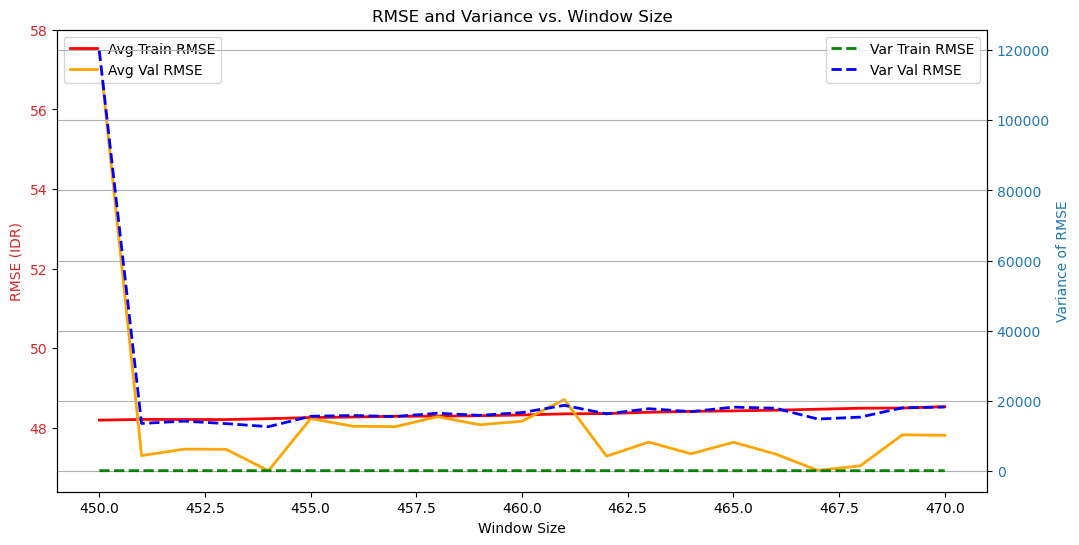

In [98]:
import matplotlib.pyplot as plt

# Ensure you have results_summary populated before running this code
if not results_summary.empty:
    # Plotting RMSE and Variance
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # RMSE Plot
    color = 'tab:red'
    ax1.set_xlabel('Window Size')
    ax1.set_ylabel('RMSE (IDR)', color=color)

    # Plot average RMSE as lines without points
    ax1.plot(results_summary['window_size'].values, results_summary['avg_train_rmse'].values, 
              label='Avg Train RMSE', color='red', linewidth=2)
    ax1.plot(results_summary['window_size'].values, results_summary['avg_val_rmse'].values, 
              label='Avg Val RMSE', color='orange', linewidth=2)

    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Create a second y-axis for variance
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Variance of RMSE', color=color)  # Set the label for the second Y axis

    # Plot variance of RMSE as lines without points
    ax2.plot(results_summary['window_size'].values, results_summary['var_train_rmse'].values, 
             label='Var Train RMSE', color='green', linestyle='--', linewidth=2)
    ax2.plot(results_summary['window_size'].values, results_summary['var_val_rmse'].values, 
             label='Var Val RMSE', color='blue', linestyle='--', linewidth=2)

    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('RMSE and Variance vs. Window Size')
    plt.grid()
    plt.show()
else:
    print("Results summary is empty.")

In [100]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Separate df into features and target
features_df = combined_df.drop(['date', 'next_close'], axis=1)
target_df = combined_df['next_close']
date_df = combined_df['date']

# Convert to NumPy arrays
X = features_df.values
y = target_df.values

# Specify parameters for the sliding window approach
window_size = 453  # Optimal window size
gap = 1            # Step size of each window
num_display = 10    # Number of recent predictions to display

# Lists to store validation and training RMSEs (excluding the last window from avg calculations)
all_val_rmse = []
all_val_rmse_perc = []
all_train_rmse = []
all_train_rmse_perc = []

# Store predictions only for the final days
last_predictions = []

# Number of windows to process
num_windows = len(X) - window_size - 1  # Exclude last row for training

# Loop through each sliding window
window_number = 0
while window_number <= num_windows:
    start = window_number
    end = start + window_size
    X_train = X[start:end]
    y_train = y[start:end]

    # Prepare validation data for prediction
    if end < len(X) - 1:  # Ensure there's data for validation
        X_val = X[end:end + 1]  # Validation is the next row after the current window
        y_val = y[end:end + 1]  # The target for validation
        val_date = date_df.iloc[end:end + 1].values  # Get the date for validation

        # Skip this iteration if y_train contains NaN
        if np.isnan(y_train).any() or np.isnan(y_val).any():
            window_number += gap
            continue

        # Initialize and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict on validation data
        y_pred_val = model.predict(X_val)

        # Calculate RMSE and RMSE percentage for validation
        mse_val = np.mean((y_val - y_pred_val) ** 2)
        rmse_val = np.sqrt(mse_val)
        rmse_val_perc = (rmse_val / y_val)[0] * 100  # Convert to percentage

        # Calculate RMSE for training
        y_pred_train = model.predict(X_train)
        mse_train = np.mean((y_train - y_pred_train) ** 2)
        rmse_train = np.sqrt(mse_train)
        rmse_train_perc = (rmse_train / y_train).mean() * 100  # Convert to percentage

        # Append RMSEs and percentage errors, excluding the last window from averages
        if end < len(X) - 1:  # Only add if it's not the last window
            all_val_rmse.append(rmse_val)
            all_val_rmse_perc.append(rmse_val_perc)
            all_train_rmse.append(rmse_train)
            all_train_rmse_perc.append(rmse_train_perc)

        # Check if we're in the last 3 windows to display
        if end >= len(X) - num_display:
            # Use the date for the next row as the prediction date
            next_row_date = date_df.iloc[end + 1]
            last_predictions.append((next_row_date, y_val[0], y_pred_val[0]))

    # Move to the next window based on the gap
    window_number += gap

# Use the features of the last row for prediction
if len(X) > 0:
    last_row_features = X[-1].reshape(1, -1)  # Reshape to 2D for prediction
    last_row_pred = model.predict(last_row_features)
    last_row_date = date_df.iloc[-1]

    # Append the last row prediction with the correct date
    last_predictions.append((last_row_date + pd.Timedelta(days=1), np.nan, last_row_pred[0]))

# Print the most recent predictions and actual values for the last three days
print("\nRecent Predictions and Actual Values:")
for i, (date, actual, pred) in enumerate(reversed(last_predictions)):
    if np.isnan(actual):
        print(f"Date: {date.date()}, Prediction: {pred:.0f}")
    else:
        error = abs(actual - pred)  # Calculate the absolute error
        error_perc = ((pred/actual)-1)*100
        print(f"Date: {date.date()}, Prediction: {pred:.0f}, Actual: {actual:.0f},  Error: {error:.0f}, Error %: {error_perc:.2f}%")


Recent Predictions and Actual Values:
Date: 2024-10-24, Prediction: 15670
Date: 2024-10-23, Prediction: 15541, Actual: 15586,  Error: 45, Error %: -0.29%
Date: 2024-10-22, Prediction: 15522, Actual: 15556,  Error: 34, Error %: -0.22%
Date: 2024-10-21, Prediction: 15449, Actual: 15467,  Error: 18, Error %: -0.11%
Date: 2024-10-18, Prediction: 15553, Actual: 15493,  Error: 60, Error %: 0.39%
Date: 2024-10-17, Prediction: 15521, Actual: 15584,  Error: 63, Error %: -0.40%
Date: 2024-10-16, Prediction: 15565, Actual: 15579,  Error: 14, Error %: -0.09%
Date: 2024-10-15, Prediction: 15563, Actual: 15573,  Error: 10, Error %: -0.07%
Date: 2024-10-14, Prediction: 15590, Actual: 15562,  Error: 28, Error %: 0.18%
Date: 2024-10-11, Prediction: 15728, Actual: 15671,  Error: 57, Error %: 0.36%
